- Libraries

In [1]:
import pandas as pd
import numpy as np
from DateTime import DateTime
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
# from statsmodels.tsa.stattools import adfuller
# from sklearn.metrics import mean_squared_error
# from statsmodels.tools.eval_measures import rmse
# from sklearn import metrics
import warnings

warnings.filterwarnings("ignore")
from src.functions_torch import TransformLag
from src.feature import TimeConfig


In [2]:
timec= TimeConfig()
df= timec.process_chain(path='../Data/apple.csv',columns=['Close/Last'])


In [3]:
df= df.loc['2021':'2024'].copy()

In [4]:
df


,Value
Date,
2021-01-04,129.41
2021-01-05,131.01
2021-01-06,126.60
2021-01-07,130.92
2021-01-08,132.05
...,...
2024-05-22,190.90
2024-05-23,186.88
2024-05-24,189.98


- Plotting the Data

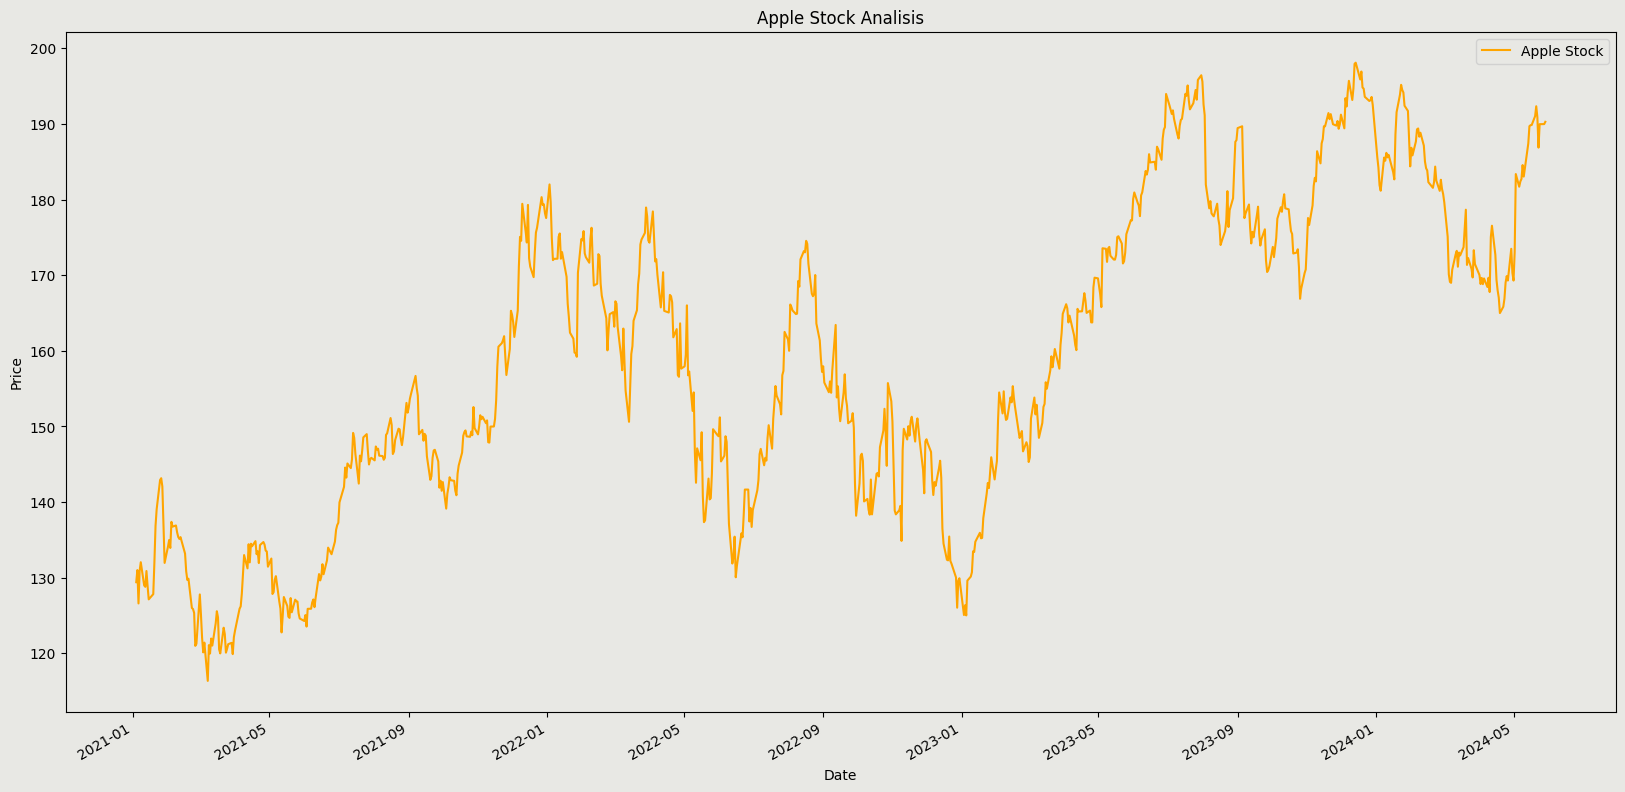

In [5]:
df["Value"].plot(figsize=(20,10),label="Apple Stock",color="orange")
plt.title("Apple Stock Analisis")
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().set_facecolor("#E8E8E4")
plt.gcf().set_facecolor("#E8E8E4")
plt.legend(facecolor="#E8E8E4")
plt.show()

In [6]:
n_steps= 1
timef= TransformLag()
data= timef.lag_transform(df,n_steps)

In [7]:
data= data.to_numpy()

- Escalado de valores del array entre -1,1 para alimentar el modelo

In [8]:
scaler= MinMaxScaler(feature_range=(-1,1))
transformed= scaler.fit_transform(data)


- Haciendo Slicing para dividir el dato de entrenamiento y el target

In [9]:
X= transformed[:,1:]
y= transformed[:,0]

In [10]:
X=dc(np.flip(X,axis=1))
split_index= int(len(X) * 0.80)
X_train= X[:split_index]
X_test= X[split_index:]
y_train= y[:split_index]
y_test= y[split_index:]

In [11]:
X_train= X_train.reshape((-1,1,1))
X_test= X_test.reshape((-1,1,1))
y_train= y_train.reshape((-1,1))
y_test= y_test.reshape((-1,1))

In [12]:
X_train= torch.tensor(X_train).float()
X_test= torch.tensor(X_test).float()
y_train= torch.tensor(y_train).float()
y_test= torch.tensor(y_test).float()

In [13]:
class TimeSeries(Dataset):
    def __init__(self,X,y):
        self.X= X
        self.y= y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        return self.X[i],self.y[i]

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    
# seed=42
# set_seed(seed)
batch_size = 10
train_dataset= TimeSeries(X_train,y_train)
test_dataset= TimeSeries(X_test,y_test)

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [14]:
for _,batch in enumerate(train_loader):
    x_batch,y_batch= batch[0].to(device),batch[1].to(device)
    print(x_batch.shape,y_batch.shape)
    break

class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_stacked_layers,dropout_rate=0.05):
        super().__init__()
        self.hidden_size= hidden_size
        self.num_stacked_layers= num_stacked_layers
        
        self.lstm= nn.LSTM(input_size,hidden_size,num_stacked_layers,
                           batch_first=True,dropout=dropout_rate)
        self.fc= nn.Linear(hidden_size,1)
        
    def forward(self,x):
        batch_size= x.size(0)
        h0= torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        c0= torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        
        out,_ = self.lstm(x,(h0,c0))
        out= self.fc(out[:,-1,:])
        return out
    
model= LSTM(1,4,1)
model.to(device)

torch.Size([10, 1, 1]) torch.Size([10, 1])


LSTM(
  (lstm): LSTM(1, 4, batch_first=True, dropout=0.05)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [15]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
def train_one_epoch():
    model.train(True)
    running_loss = 0.0

    for _, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_train_loss = running_loss / len(train_loader)
    return avg_train_loss
  
    
def validate_one_epoch():
    model.eval()
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    return avg_loss_across_batches

 

Epoch 1/10, Train Loss: 0.28061896171420814, Validation Loss: 0.7886760628223419
Epoch 2/10, Train Loss: 0.16816834941506387, Validation Loss: 0.41555328845977785
Epoch 3/10, Train Loss: 0.08897082287818193, Validation Loss: 0.17776310652494431
Epoch 4/10, Train Loss: 0.036758729382418094, Validation Loss: 0.06575325932353734
Epoch 5/10, Train Loss: 0.012817475591873517, Validation Loss: 0.02329388845944777
Epoch 6/10, Train Loss: 0.006711340498877689, Validation Loss: 0.012069571409374475
Epoch 7/10, Train Loss: 0.005837698932737112, Validation Loss: 0.009154323576949537
Epoch 8/10, Train Loss: 0.005715871703578159, Validation Loss: 0.008395449761301278
Epoch 9/10, Train Loss: 0.005676416773349046, Validation Loss: 0.007702897586859762
Epoch 10/10, Train Loss: 0.005656813889509067, Validation Loss: 0.007366260092239827


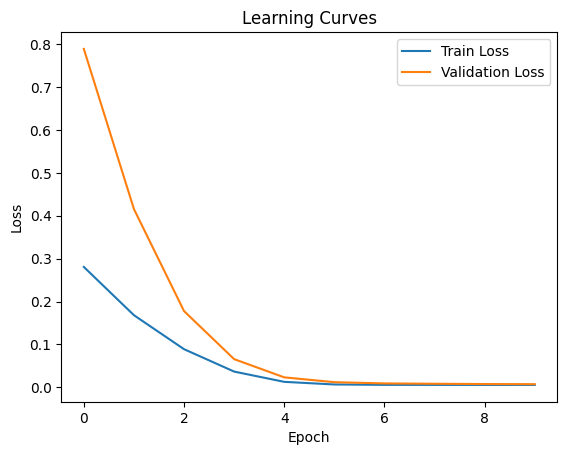

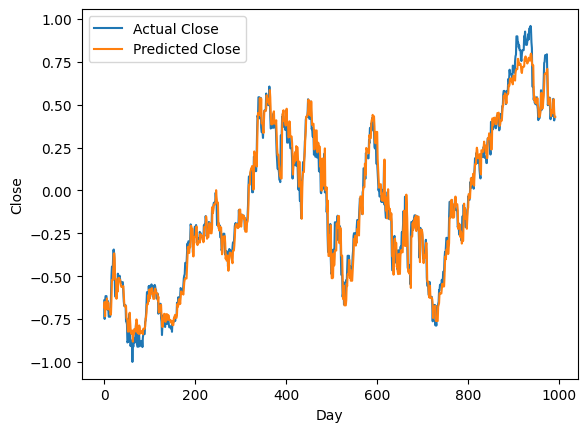

In [17]:
train_losses=[]
val_losses=[]

for epoch in range(num_epochs):
    train_loss= train_one_epoch()
    val_loss= validate_one_epoch()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

    with torch.no_grad():
        model.eval()
        predicted = model(X_train.to(device)).to('cpu').numpy()

# Plotting the learning curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')
plt.show()
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

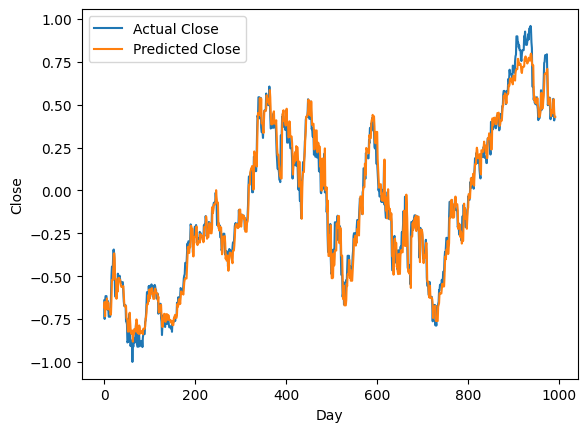

In [18]:
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [19]:
train_predictions = predicted.flatten()
dummies = np.zeros((X_train.shape[0], 1+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)
train_predictions = dc(dummies[:, 0])


In [20]:
dummies = np.zeros((X_train.shape[0], 1+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])


In [21]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], 1+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])


In [22]:
dummies = np.zeros((X_test.shape[0], 1+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])


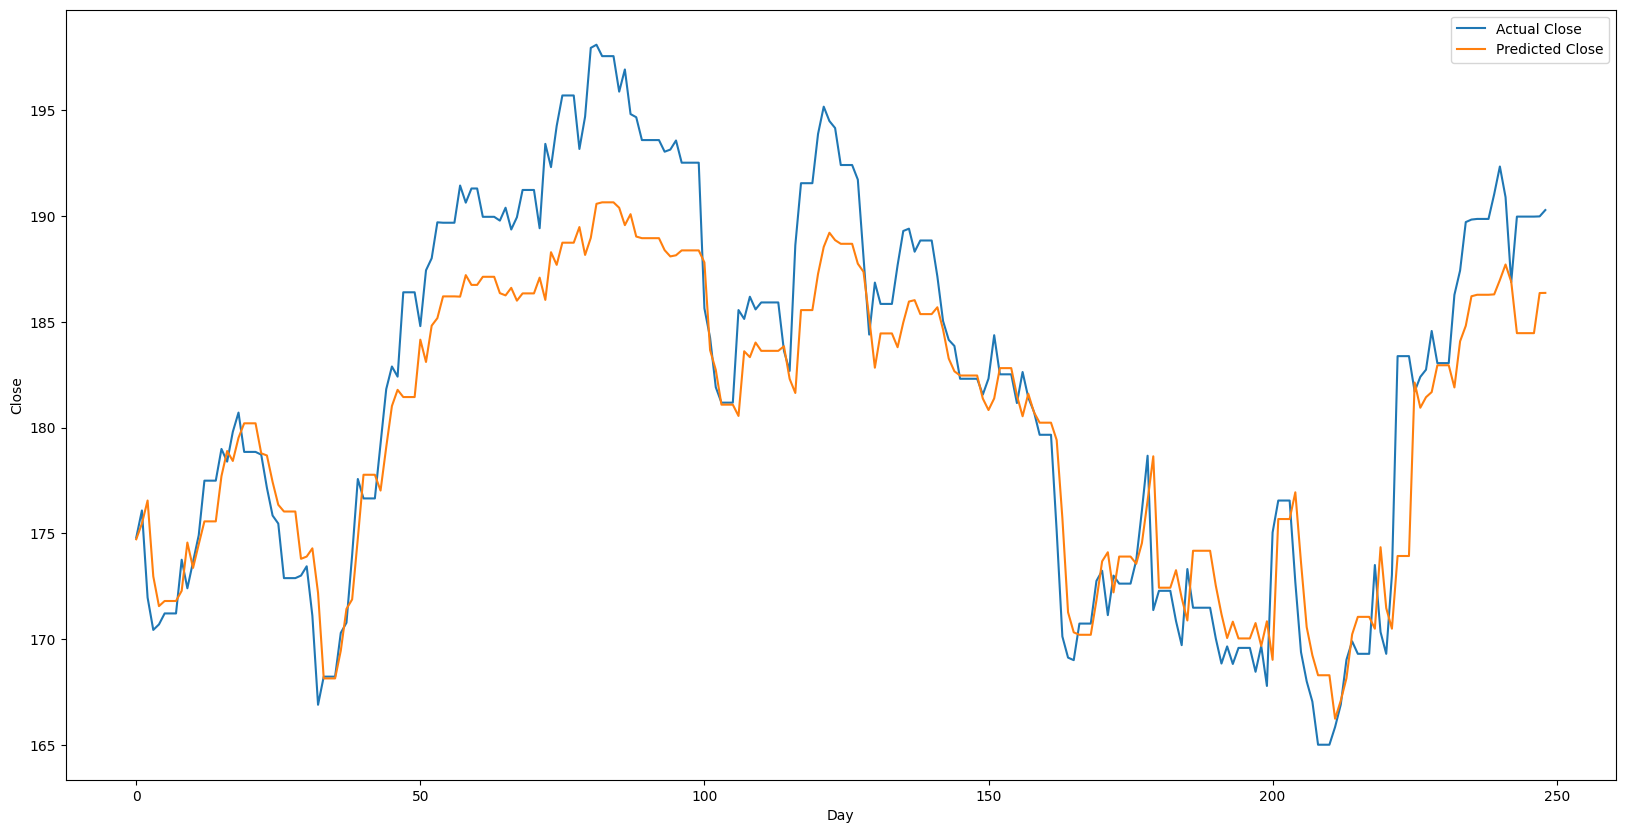

In [23]:
plt.figure(figsize=(20,10))
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [24]:
new_y_test

array([174.79000054, 176.07999985, 171.96000054, 170.42999982,
       170.68999992, 171.21000012, 171.21000012, 171.21000012,
       173.75000014, 172.39999986, 173.66000053, 174.91000002,
       177.48999987, 177.48999987, 177.48999987, 178.9899995 ,
       178.38999965, 179.79999967, 180.70999941, 178.85000011,
       178.85000011, 178.85000011, 178.71999945, 177.15000012,
       175.83999967, 175.46000009, 172.88000023, 172.88000023,
       172.88000023, 172.99999972, 173.44000026, 171.10000059,
       166.88999984, 168.21999959, 168.21999959, 168.21999959,
       170.29000042, 170.76999958, 173.97000041, 177.56999953,
       176.64999984, 176.64999984, 176.64999984, 179.23000091,
       181.82000072, 182.88999976, 182.40999939, 186.40000048,
       186.40000048, 186.40000048, 184.80000006, 187.44000088,
       188.00999964, 189.70999963, 189.68999972, 189.68999972,
       189.68999972, 191.44999944, 190.63999928, 191.31000005,
       191.31000005, 189.97000095, 189.97000095, 189.97

In [25]:
test_predictions

array([174.71868643, 175.46162147, 176.55026583, 172.96552307,
       171.55540855, 171.79798029, 171.79798029, 171.79798029,
       172.27952286, 174.56145724, 173.36324581, 174.48261728,
       175.56419625, 175.56419625, 175.56419625, 177.70471572,
       178.89224137, 178.42224705, 179.51617826, 180.20274614,
       180.20274614, 180.20274614, 178.78317374, 178.68156619,
       177.42972848, 176.35007178, 176.03090639, 176.03090639,
       176.03090639, 173.79310143, 173.89990813, 174.28926935,
       172.17805905, 168.13704588, 168.13704588, 168.13704588,
       169.44608397, 171.42429935, 171.87237636, 174.75354558,
       177.76910575, 177.76910575, 177.76910575, 177.02141985,
       179.07837286, 181.01974591, 181.78624279, 181.44493594,
       181.44493594, 181.44493594, 184.15905752, 183.10395669,
       184.82163476, 185.17716496, 186.20620183, 186.20620183,
       186.20620183, 186.19436609, 187.21223965, 186.74973951,
       186.74973951, 187.13301475, 187.13301475, 187.13

In [26]:
import matplotlib.pyplot as plt

# Redefine the DataLoader for retraining if necessary
new_train_loader = test_loader

def train_one_epoch():
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Forward pass
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = running_loss / len(new_train_loader.dataset)
    return avg_train_loss

# Training loop
train_losses = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch()
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}')

    # Prediction for plotting
    with torch.no_grad():
        model.eval()
        predicted = model(X_train.to(device)).cpu().numpy()

Epoch 1/10, Train Loss: 0.0022500269344061553
Epoch 2/10, Train Loss: 0.0022953524615196698
Epoch 3/10, Train Loss: 0.0022240679025702387
Epoch 4/10, Train Loss: 0.0022163641050899304
Epoch 5/10, Train Loss: 0.002229239843060154
Epoch 6/10, Train Loss: 0.002192942876308917
Epoch 7/10, Train Loss: 0.0022010224568377056
Epoch 8/10, Train Loss: 0.002202153714078228
Epoch 9/10, Train Loss: 0.002163918914360342
Epoch 10/10, Train Loss: 0.0021634834428620807


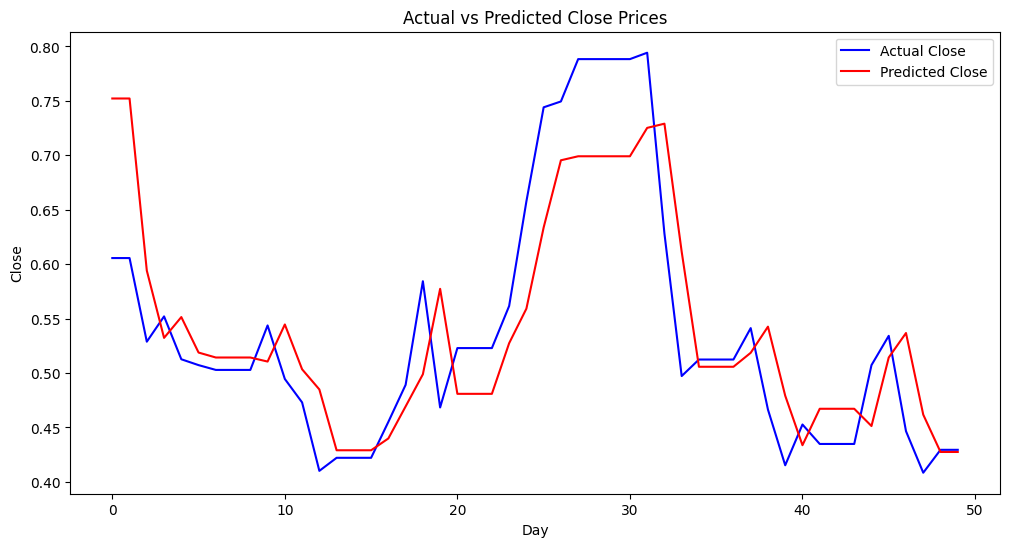

In [27]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train[-50:], label='Actual Close', color='blue')
plt.plot(predicted[-50:], label='Predicted Close', color='red')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title('Actual vs Predicted Close Prices')
plt.show()

In [28]:
"""new_train_loader= test_loader

def train_one_epoch():
    model.train(True)
    running_loss = 0.0

    for _, batch in enumerate(new_train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_train_loss = running_loss / len(new_train_loader)
    return avg_train_loss

train_losses=[]

for epoch in range(num_epochs):
    train_loss= train_one_epoch()
    
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}')

    with torch.no_grad():
        model.eval()
        predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train[-50:], label='Actual Close')
plt.plot(predicted[-50:], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()"""

"new_train_loader= test_loader\n\ndef train_one_epoch():\n    model.train(True)\n    running_loss = 0.0\n\n    for _, batch in enumerate(new_train_loader):\n        x_batch, y_batch = batch[0].to(device), batch[1].to(device)\n\n        output = model(x_batch)\n        loss = loss_function(output, y_batch)\n        running_loss += loss.item()\n\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n    avg_train_loss = running_loss / len(new_train_loader)\n    return avg_train_loss\n\ntrain_losses=[]\n\nfor epoch in range(num_epochs):\n    train_loss= train_one_epoch()\n    \n    train_losses.append(train_loss)\n    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}')\n\n    with torch.no_grad():\n        model.eval()\n        predicted = model(X_train.to(device)).to('cpu').numpy()\n\nplt.plot(y_train[-50:], label='Actual Close')\nplt.plot(predicted[-50:], label='Predicted Close')\nplt.xlabel('Day')\nplt.ylabel('Close')\nplt.legend()\nplt.show()"